<a href="https://colab.research.google.com/github/sayanbanerjee32/NLP-with-fastai2.0/blob/main/fastai_on_20newsgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai 2 version

uncomment if required

In [3]:
#!pip install fastai==2.1.4
# --upgrade

# Data
Import data

In [4]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

In [5]:
def twenty_newsgroup_to_df(data_set = 'train'):
    newsgroups_data = fetch_20newsgroups(subset=data_set, 
                                          remove=('headers', 'footers',
                                                  'quotes'))

    df = pd.DataFrame([newsgroups_data.data, 
                       newsgroups_data.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(newsgroups_data.target_names)
    targets.columns = ['title']

    data_set = pd.merge(df, targets, left_on='target', right_index=True)
    #out['date'] = pd.to_datetime('now')
    #out.to_csv('20_newsgroup.csv')
    return data_set


train_data_df = twenty_newsgroup_to_df('train')
test_data_df = twenty_newsgroup_to_df('test')

In [6]:
train_data_df.info(),test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
 2   title   11314 non-null  object
dtypes: object(3)
memory usage: 353.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7532 entries, 0 to 7519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7532 non-null   object
 1   target  7532 non-null   object
 2   title   7532 non-null   object
dtypes: object(3)
memory usage: 235.4+ KB


(None, None)

Number of classes in train and test

In [7]:
len(train_data_df.target.unique()),len(train_data_df.title.unique())

(20, 20)

In [8]:
len(test_data_df.target.unique()),len(test_data_df.title.unique())

(20, 20)

## is_validation column

In [9]:
from fastai.text.all import *

In [10]:
 np.random.seed(1)
 msk = np.random.rand(train_data_df.shape[0]) < 0.2
 train_data_df['is_valid'] = msk
 print(train_data_df.groupby(['is_valid','title'])['text'].count())

is_valid  title                   
False     alt.atheism                 366
          comp.graphics               474
          comp.os.ms-windows.misc     466
          comp.sys.ibm.pc.hardware    475
          comp.sys.mac.hardware       462
          comp.windows.x              474
          misc.forsale                471
          rec.autos                   472
          rec.motorcycles             492
          rec.sport.baseball          457
          rec.sport.hockey            474
          sci.crypt                   486
          sci.electronics             468
          sci.med                     487
          sci.space                   487
          soc.religion.christian      489
          talk.politics.guns          417
          talk.politics.mideast       461
          talk.politics.misc          381
          talk.religion.misc          308
True      alt.atheism                 114
          comp.graphics               110
          comp.os.ms-windows.misc     125

## Clean the text column

In [11]:
train_data_df['text'] = train_data_df['text'].replace('\n|\t',' ', regex=True)
test_data_df['text'] = test_data_df['text'].replace('\n|\t',' ', regex=True)

In [12]:
#train_data_df.loc[train_data_df['text'].str.contains('uslims can carry on our holy cause')]



# Initial model using transfer learning

## create data loader from data frame

Defining a seed for reproducible results

In [13]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [14]:
#random_seed(32, True)
dls = TextDataLoaders.from_df(train_data_df, text_col='text', label_col='title',
                              valid_col='is_valid', seed=1, shuffle_train=True)

# newsgroup_clas = DataBlock(
#     blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
#     get_x=ColReader('text'), get_y=ColReader('title'), splitter=ColSplitter())

# dls = newsgroup_clas.dataloaders(train_data_df) 

dls.show_batch(max_n=5)

,text,category
0,"xxbos xxmaj archive - name : hockey - faq rec.sport.hockey answers to xxmaj frequently xxmaj asked xxmaj questions and other news : xxmaj contents : 0 . xxmaj new xxmaj info . 1 . xxup nhl 2 . xxup nhl xxmaj minor xxmaj leagues 3 . xxmaj college xxmaj hockey ( north xxmaj america ) 4 . xxmaj other leagues ( e.g. xxmaj europe , xxmaj canada xxmaj cup tournament ) 5 . xxmaj e - mail files 6 . xxup usenet xxmaj hockey xxmaj pool 7 . xxmaj up - coming xxmaj dates 8 . xxmaj answers to some frequently asked questions 9 . xxmaj miscellaneous xxmaj send comments , suggestions and criticisms regarding this xxup faq list via xxunk mail to hamlet@u.washington.edu . xxrep 74 - 0 . xxmaj new xxmaj info . xxmaj this section will describe additions since the last post so that you can decide",rec.sport.hockey
1,"xxbos xxrep 12 - xxmaj part 2 of 14 xxrep 12 - xxup m0 . / xxup xxunk / xxup cbn / xxup xxunk / xxup xxunk , xxunk , xxunk [ xxup xxunk \ _ -8 xxup my _ / xxup sys * / xxup xxunk \ xxup xxunk > / xxup c^ > / xxup cx_s \ xxup xxunk _ / xxup sc _ . / xxup xxunk _ . / xxup c _ / xxup gcx^ / xxup y _ . / m \ xxup x_scx^ / \ _ . / xxup c _ / s \ _ . / \ xxup x^ / \ xxup x^ / xxup cx_scx^ / xxup c _ . / xxup cx^ / \ xxup x^ / xxup c _ . / xxup cx^ / xxup cx^ / m \ xxup xxunk _ . / \ xxup x^ / xxup c",comp.os.ms-windows.misc
2,"xxbos xxrep 10 - cut here xxrep 10 - part 01 / 01 begin 644 xxunk xxup xxunk 1d & -$ , _ _ \ @ p $ ? # _ ' @ ! xxunk ( # $ y. # xxup dm xxup xxunk < v5r = xxunk * m _ "" z , # f \ $ h0 ( xxup c , xxunk ( . \ -r xxup rt ! xxunk / j \ * xxunk / xxup xxunk . xxup xxunk * % [ ! * xxunk xxup xxunk "" zc < xxunk & xxunk + h8 ! xxunk xxup xxunk _ # xxup xxunk / xxup xxunk [ b \ xxup xxunk , xxup xxunk / xxunk / / \ xxup xxunk / [ xxunk xxunk \ xxup xxunk # / xxup xxunk > xxunk # xxup cl xxup xxunk / xxup xxunk / _ xxunk xxup",comp.os.ms-windows.misc
3,"xxbos xxmaj accounts of anti - armenian xxmaj human xxmaj right xxmaj violations in xxmaj azerbaijan # 008 xxmaj part b xxmaj prelude to xxmaj current xxmaj events in nagorno - karabakh ( part b of # 008 ) + xxrep 66 - + | | | "" oh , yes , i just remembered . xxmaj while they were raping me they | | repeated quite frequently , "" let the xxmaj armenian women have babies | | for us , xxmaj muslim babies , let them bear xxmaj azerbaijanis for the | | struggle against the xxmaj armenians . "" xxmaj then they said , "" those | | xxmaj muslims can carry on our holy cause . xxmaj heroes ! "" xxmaj they repeated | | it very often . "" | | | + xxrep 66 - + … continued from xxup part xxup a :",talk.politics.mideast
4,"xxbos xxmaj try the firearms archive . xxmaj larry xxmaj cipriani 's instructions follow . xxmaj by the way , thanks for the archive xxmaj larry .. xxmaj this year is the 103rd congress directory . xxrep 28 - xxmaj from xxunk xxunk . xxunk xxmaj thu xxmaj apr 8 xxunk 1993 xxmaj article : xxunk of talk.politics.guns xxmaj path : xxunk xxunk . xxunk xxmaj from : xxunk xxmaj newsgroups : talk.politics.guns xxmaj subject : xxmaj information about the anonymous ftp xxup rkba archive message - id : < xxunk > xxmaj date : 8 xxmaj apr 93 xxunk xxup gmt xxmaj sender : xxunk xxmaj organization : xxmaj ideology xxmaj busters , xxmaj inc . xxmaj lines : xxunk xxmaj this is the xxup index file for the anonymous ftp xxup rkba archive . xxmaj the archive site has been moved and is now at : godiva.nectar.cs.cmu.edu in",talk.politics.guns


## create text learner

use F1 score as metrics and find optimum learning rate

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=0.0004786300996784121)

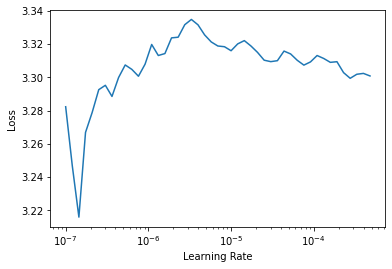

In [15]:
#dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
fscore = F1Score(average='weighted')
#ls_func = CrossEntropyLossFlat()
#random_seed(32, True)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                #loss_func = ls_func,
                                metrics=[accuracy,fscore])
#learn.fine_tune(2, 1e-2)
learn.lr_find()

In [16]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,1.643028,0.499332,0.500433,01:03


Tune the model with suggested learning rate that is min learning rate devided by 10.

In [17]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,1.719404,0.469070,0.470529,01:03


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,1.390211,0.560748,0.563728,01:54
1,nan,1.272790,0.605696,0.600804,01:53
2,nan,1.192154,0.642190,0.646807,01:54
3,nan,1.167153,0.660436,0.659298,01:54
4,nan,1.149600,0.665777,0.665287,01:53


In [18]:
#learn.fit_one_cycle(1, 0.001) # min / 10
#learn.fit_one_cycle(1, 2e-2)

In [19]:
#learn.freeze_to(-2)
#learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [20]:
#learn.freeze_to(-3)
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [21]:
#learn.unfreeze()
#learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

In [22]:
#learn.fine_tune(5,0.01)

## Predict on test data

In [23]:
predict_df = test_data_df.text.apply(learn.predict)
#predict_df.head()
predict_df_class = [x[0] for x in predict_df.values]
predict_df_prob = [max(x[2].tolist()) for x in predict_df.values]
print(predict_df_class[:10])
print(predict_df_prob[:10])

['rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'misc.forsale']
[0.6384721398353577, 0.6335111856460571, 0.9977403879165649, 0.5531231164932251, 0.9973535537719727, 0.9777987599372864, 0.9957579970359802, 0.9723925590515137, 0.9900396466255188, 0.7635321617126465]


## Classification report

In [24]:
from sklearn.metrics import classification_report

In [25]:
act_class = [str(c) for c in test_data_df.title.values]
len(np.unique(act_class))

20

In [26]:
print(classification_report(act_class, predict_df_class))

                          precision    recall  f1-score   support

             alt.atheism       0.36      0.44      0.39       319
           comp.graphics       0.52      0.61      0.56       389
 comp.os.ms-windows.misc       0.47      0.54      0.50       394
comp.sys.ibm.pc.hardware       0.50      0.53      0.51       392
   comp.sys.mac.hardware       0.58      0.51      0.55       385
          comp.windows.x       0.69      0.59      0.64       395
            misc.forsale       0.77      0.80      0.78       390
               rec.autos       0.66      0.65      0.66       396
         rec.motorcycles       0.58      0.67      0.62       398
      rec.sport.baseball       0.77      0.80      0.78       397
        rec.sport.hockey       0.58      0.86      0.69       399
               sci.crypt       0.73      0.55      0.63       396
         sci.electronics       0.52      0.50      0.51       393
                 sci.med       0.86      0.74      0.79       396
         